# Constellation and Chain Analysis: MultiConstellation Multihop MultiPath

<img src="MultipleConstellations.jpg" alt="Drawing" style="width: 500px;"/>

**Terminology**
* Node = Object in STK
* Edge = Access between two objects in STK
* Strand = The sequence of nodes and edges to complete access in a chain

**This notebook shows how to:**
* Find the shortest path between a starting and ending constellation, with many potential intermediate constellations.
* A chain will be built between each sequential pair in the constellationOrder list. Then networkx will be used build the network with the nodes coming from the constellations and the connections between the nodes coming from the chain accesses. Multiple sublists can be passed into constellationOrderList.
* Typical STK constraints such as range, link duration, Eb/No, etc are taken into account
* Data in the df variable can be pushed back into STK as a user supplied variable, a strand can be shown using object lines, and active objects over the analysis time period or at a time instance can be turned on.

**To reduce the runtime on subsequent runs, this scripts saves various computations to binary files and are reused for subsequent runs.** 
* The strands from the chains will be saved in the SavedNodes folder
* the nodes and associated time delays will be saved in the SavedNodes folder
* the node positions over time are saved in the SavedPositions folder
* the accesses between nodes over time are saved in the SavedEdges folder. 
* These folders will be created as subfolders of the directory used to run the script.
* During the first run the files will automatically be built and saved, subsequent runs will reload these files.
* To make changes simply delete the associated .pkl file for any changed strands, nodes, etc. and the script will recompute the data as needed. Or force all of the data to be overridden by setting the override options to be True.

In [1]:
import numpy as np
import pandas as pd
pd.set_option('max_colwidth', 120)
from comtypes.client import CreateObject
from comtypes.client import GetActiveObject
from comtypes.gen import STKObjects
from comtypes.gen import STKUtil
from comtypes.gen import AgSTKVgtLib
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib import cm
from chainPathLib2 import *
import time
import networkx as nx

folders = ['SavedNodes','SavedPositions','SavedStrands','SavedEdges','SavedNetworkData']
for folder in folders:
    if not os.path.exists(folder):
        os.makedirs(folder)
import warnings
warnings.filterwarnings('ignore') # Ignore some numpy indexing warnings

## Constellation Connection Order, Computation Time, Save Data Options

Often the hardest part of network analysis is defining the constellation order. Here are some tips:

* Every pair of constellations in the constellationOrderLists will create a one way flow of information (a directed edge) .i.e. [constellation1,constellation2] means constellation1 -> constellation2 but **NOT** constellation2 -> constellation1
    
* To allow for multiple hops between constellations the constelltionOrderLists needs to create a cycle:
    * If you want a constellation to link to itself simply order [constellation1,constellation1]
    * If you want to link to another constellation before linking back to the original [constellation1,constellation2,constellation1]
    * Theoreitcally this cycle can be as big as you want. [c1,c2,....,cN,c1]
    * The reason adding cycles of constellations works is because constellations have multiple objects, so the connections will always be to different objects in the constellation therefore you won't revisit specific nodes in the final path. If the constellation at the beginning of the cycle has only 1 object the cycle will be ignored
    * <img src="CycleIllustration.jpg" alt="Drawing" style="width: 500px;"/>
* The constellationOrderLists **does NOT** require the final path to include every constellation in order, it will find the shortest path among possible connections and cut out unneccesary looping. For example, say you define consetllationOrderLists to be [[start,satConstellation,satConstellation,end]] because you want to allow for intersatellite links in satConstellation, the shortest path may just be from start->satConstellation->end without the need for intersatellitelinks, in which case the intersatellite linking will not be used.
    * This code does not force the use of a cycle aka force intersatellite links to be used in the above example. If you want to do this you have 2 options. Use the prebuilt chains notebook (but it doesn't support multiple hops) or compute multiple shortest paths and filter out any which don't have the desired properties. In the future an improvement may be made to add additional constraints on the shortest path.
    
* To constrain the path for children objects (sensors, transmitters, recievers) you may need to add logical Parent "From" and "To" constraints on the constellations in STK. Think of "From" as the 1st position in a connection (aka transmitting) and "To" as the 2nd position in a connection (aka reiceving). Often you want transmitters to have a "From" Different Parents constraint and recievers to have a "From" Same Parents constraint. The constellation ordering can be set up in a way to force the paths to contain the parent object or to bypass it and only use the children objects. i.e. only use transmitters and recievers and not go to a satellite bus first. For example either of the following orderings could be valid [recievers,satellites,transmitters] (the satellites constellation would need a "From" Same Parent constraint) or [transmitters,receivers].

In [2]:
# The constellationOrderLists builds a directed chain for each adjacent pair in the list
# i.e.: constellationOrderLists = [[A,B],[X,Y,Z,X]] would build chainAB,chainXY,chainYZ,chainZX
constellationOrderLists = [['Targets','ObservingSatsFORs','ObservingSats','ObservingSatsTransmitters','ObservingSatsReceivers','ObservingSats','RelaySatsFORs','RelaySats','RelaySatsFORs','EndLocations'],['RelaySats','RelaySats']]   

startingConstellation = 'Targets' # complete path starting constellation
endingConstellation = 'EndLocations' # complete path ending constellation

start = 0 # EpSec
stop = 120*60 # EpSec
step = 10 # sec # Time resolution of computations
nodeDelays = {'ObservingSatsFORs':0.01,'ObservingSatsTransmitters':0.005,'ObservingSatsReceivers':0.005,'RelaySatsFORs':0.01,'RelaySats':0.002} # Add in time delays. Provide the constellation name in STK and the node delays
                           
stkVersion = 12
overrideStrands = False # Override previously computed chains
overrideNodeDelaysByNode = False # Override previously built node delay dictionaries
overrideNodesTimesPos = False # Override previously built node positions

In [3]:
# Connect to STK
stkApp = GetActiveObject('STK{}.Application'.format(stkVersion))
stkRoot = stkApp.Personality2
stkRoot.Isolate()
stkRoot.UnitPreferences.SetCurrentUnit('DateFormat','EpSec') # Units to EpSec for ease of use
stkRoot.ExecuteCommand('Units_SetConnect / Date "EpochSeconds"');
try:
    stkRoot.ExecuteCommand('VO * ObjectLine DeleteAll'); # Clean up old object lines
except:
    pass

# Build chains and create a dict of time delays for each node
t1 = time.time()
chainNames = createDirectedChains(stkRoot,constellationOrderLists,start=start,stop=stop,color=12895232)   
print(time.time()-t1)
t1 = time.time()
nodeDelaysByNode = getNodeDelaysByNode(stkRoot,nodeDelays,chainNames=chainNames,overrideData=overrideNodeDelaysByNode)
print(time.time()-t1)

startingNodes = getNodesFromConstellation(stkRoot,startingConstellation)
endingNodes = getNodesFromConstellation(stkRoot,endingConstellation)

0.6266028881072998
0.0030279159545898438


## Compute Strands, Strands at Each Time, Node Positions, Edges, Distances, Time Delays

Only need to run this section once unless you change the section above, i.e. the objects in the constellations,the constellation ordering, the start, stop and step times, nodeDelays


In [4]:
# Compute strands, (this is actually a list of all intervals for each edge)
t1 = time.time()
# strands,dfStrands = getAllStrands(stkRoot,chainNames,start,stop,overrideData=overrideStrands)
strands = getAllStrands(stkRoot,chainNames,start,stop,overrideData=overrideStrands)[0] # if memory or performance is an issue don't output dfStrands
print(time.time()-t1)
# dfStrands

Loaded TargetsToObservingSatsFORs.pkl
Loaded ObservingSatsFORsToObservingSats.pkl
Loaded ObservingSatsToObservingSatsTransmitters.pkl
Loaded ObservingSatsTransmittersToObservingSatsReceivers.pkl
Loaded ObservingSatsReceiversToObservingSats.pkl
Loaded ObservingSatsToRelaySatsFORs.pkl
Loaded RelaySatsFORsToRelaySats.pkl
Loaded RelaySatsToRelaySatsFORs.pkl
Loaded RelaySatsFORsToEndLocations.pkl
Loaded RelaySatsToRelaySats.pkl
0.021941423416137695


In [5]:
# Compute node positions, distances and time delays

t1 = time.time()
strandsAtTimes = getStrandsAtTimes(strands,start,stop,step) # Discretize strand intervals into times
t2 = time.time()
print(t2-t1)

t1 = time.time()
nodesTimesPos = computeNodesPosOverTime(stkRoot,strands,start,stop,step,overrideData=overrideNodesTimesPos) # Pull node position over time
t2 = time.time()
print(t2-t1)

# Check if data needed for strandsAtTimes is missing, force a recomputed if needed
t1 = time.time()
strands,nodesTimesPos,strandsAtTimes = recomputeMissingData(strands,nodesTimesPos,strandsAtTimes,recomputeIfDataIsMissing=True)
t2 = time.time()
print(t2-t1)

t1 = time.time()
timeNodePos = computeTimeNodePos(strandsAtTimes,nodesTimesPos) # Nodes and positions at each time
t2 = time.time()
print(t2-t1)

t1 = time.time()
timesEdgesDistancesDelays = computeTimeEdgesDistancesDelays(strandsAtTimes,nodesTimesPos,nodeDelaysByNode,overrideData=True)  # Edges, distances and delays at each time
t2 = time.time()
print(t2-t1)

0.23993182182312012
0.08879208564758301
0.02094268798828125
0.3550553321838379
6.392086744308472


## Use NX for Network Metrics and Reliability Analysis

This notebook breaks the starting and ending nodes into unique pairs and finds the shortest path between each pair. It also supports finding the TopN best paths for each unique pair.

You can change the filename to save different runs

In [6]:
# Get pairs of each starting and ending node permutation in the constellations
nodePairs = [(start,end) for start,end in itertools.product(startingNodes, endingNodes)] # full permutation
pd.DataFrame(nodePairs,columns=['start','end'])

,start,end
0,Target/Target1,Place/Los_Angeles_CA
1,Target/Target1,Place/Washington_DC
2,Target/Target2,Place/Los_Angeles_CA
3,Target/Target2,Place/Washington_DC
4,Target/Target3,Place/Los_Angeles_CA
5,Target/Target3,Place/Washington_DC
6,Target/Target4,Place/Los_Angeles_CA
7,Target/Target4,Place/Washington_DC
8,Target/Target5,Place/Los_Angeles_CA
9,Target/Target5,Place/Washington_DC


In [7]:
# Loop through each node pair and compute network metrics
# Edit computeNetworkMetrics in chainPathLibCustom to for additional metrics
overrideNetwork = False
metric = 'distance' # 'distance' or 'timeDelay' 
filename = 'run1' # a file for each nodepair will created and the names of the node be appended to filename, leave empty if desired

for nodePair in nodePairs:
    df = computeNetworkMetrics(start,stop,step,timeNodePos,timesEdgesDistancesDelays,[nodePair[0]],[nodePair[1]],metric,computeNumNodesToLoseAccessBetweenAnyPair=False,overrideData=overrideNetwork,printTime=True,diNetwork=True,filename=filename)

0.005983829498291016
0.004984855651855469
0.003989219665527344
0.004987478256225586
0.0049860477447509766
0.003983497619628906
0.00402069091796875
0.0049877166748046875
0.003989219665527344
0.003989219665527344
0.005018949508666992
0.004985332489013672
0.003992319107055664
0.005003452301025391


In [8]:
df

,time,strand,distance,num hops,num parent hops
0,0,"[Target/Target7, Satellite/ObservingSat21/Sensor/ObservingFOR, Satellite/ObservingSat21, Satellite/ObservingSat21/Tr...",23576.173118,6.0,3.0
1,10,"[Target/Target7, Satellite/ObservingSat64/Sensor/ObservingFOR, Satellite/ObservingSat64, Satellite/ObservingSat64/Tr...",23549.939649,6.0,3.0
2,20,"[Target/Target7, Satellite/ObservingSat64/Sensor/ObservingFOR, Satellite/ObservingSat64, Satellite/ObservingSat64/Tr...",23524.538342,6.0,3.0
3,30,"[Target/Target7, Satellite/ObservingSat21/Sensor/ObservingFOR, Satellite/ObservingSat21, Satellite/ObservingSat21/Tr...",23534.828280,6.0,3.0
4,40,"[Target/Target7, Satellite/ObservingSat21/Sensor/ObservingFOR, Satellite/ObservingSat21, Satellite/ObservingSat21/Tr...",23525.677178,6.0,3.0
...,...,...,...,...,...
716,7160,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",22065.812103,6.0,3.0
717,7170,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",22051.121304,6.0,3.0
718,7180,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",22037.617748,6.0,3.0
719,7190,"[Target/Target7, Satellite/ObservingSat74/Sensor/ObservingFOR, Satellite/ObservingSat74, Satellite/ObservingSat74/Tr...",22090.481878,6.0,3.0


##  Investigate Routing between Specific Nodes

In [9]:
# Pick a starting and ending node
startingNode = 'Target/Target7'
endingNode = 'Place/Washington_DC'

In [10]:
# Load df
filenameToLoad = 'SavedNetworkData/df{}{}{}.pkl'.format(filename,startingNode.split('/')[-1],endingNode.split('/')[-1])
with open(filenameToLoad,'rb') as f:
    df = pickle.load(f)
df = addLightAndNodeDelays(df,timesEdgesDistancesDelays)    
dfIntervals = createDfIntervals(df,stop,step)
addStrandsAsObjectLines(stkRoot,dfIntervals,color='yellow')

In [11]:
# Add data back into STK for reporting and plotting
t1 = time.time()
df['distance'] = df['distance']*1000 # May need to fix meter/kilometer issue
addDataToSTK(stkRoot,chainNames[0],df) # Adds data in df back into STK to the first chain under User Supplied data
print(time.time()-t1)
df

0.6540634632110596


,time,strand,distance,num hops,num parent hops,timeDelay,lightDelay,nodeDelay
0,0,"[Target/Target7, Satellite/ObservingSat21/Sensor/ObservingFOR, Satellite/ObservingSat21, Satellite/ObservingSat21/Tr...",2.357617e+07,6.0,3.0,0.108642,0.078642,0.03
1,10,"[Target/Target7, Satellite/ObservingSat64/Sensor/ObservingFOR, Satellite/ObservingSat64, Satellite/ObservingSat64/Tr...",2.354994e+07,6.0,3.0,0.108554,0.078554,0.03
2,20,"[Target/Target7, Satellite/ObservingSat64/Sensor/ObservingFOR, Satellite/ObservingSat64, Satellite/ObservingSat64/Tr...",2.352454e+07,6.0,3.0,0.108469,0.078469,0.03
3,30,"[Target/Target7, Satellite/ObservingSat21/Sensor/ObservingFOR, Satellite/ObservingSat21, Satellite/ObservingSat21/Tr...",2.353483e+07,6.0,3.0,0.108504,0.078504,0.03
4,40,"[Target/Target7, Satellite/ObservingSat21/Sensor/ObservingFOR, Satellite/ObservingSat21, Satellite/ObservingSat21/Tr...",2.352568e+07,6.0,3.0,0.108473,0.078473,0.03
...,...,...,...,...,...,...,...,...
716,7160,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",2.206581e+07,6.0,3.0,0.103604,0.073604,0.03
717,7170,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",2.205112e+07,6.0,3.0,0.103555,0.073555,0.03
718,7180,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",2.203762e+07,6.0,3.0,0.103510,0.073510,0.03
719,7190,"[Target/Target7, Satellite/ObservingSat74/Sensor/ObservingFOR, Satellite/ObservingSat74, Satellite/ObservingSat74/Tr...",2.209048e+07,6.0,3.0,0.103686,0.073686,0.03


In [12]:
dfIntervals['strand'][0]

['Target/Target7',
 'Satellite/ObservingSat21/Sensor/ObservingFOR',
 'Satellite/ObservingSat21',
 'Satellite/ObservingSat21/Transmitter/ObservingTransmitter',
 'Satellite/ObservingSat83/Receiver/ObservingReceiver',
 'Satellite/ObservingSat83',
 'Satellite/RelaySat22/Sensor/RelaySatFOR',
 'Place/Washington_DC']

In [13]:
# Active objects in the network over time
objPaths = list(set((item for sublist in df['strand'] for item in sublist)))

In [14]:
# Turn on the objects in the scenario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'On',parentsOnly = True)

In [15]:
# Turn off the objects in the sceario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'Off',parentsOnly = True)

## Investigate Instances in Time

In [16]:
# Look at an instance in time (pick a time in df)
t = 0
stkRoot.CurrentTime = t

In [17]:
# Look at strand order and the node delay
objPaths = df['strand'][t/step]
nodeDelaysByStrand = {node:nodeDelaysByNode[node] for node in objPaths}
pd.DataFrame([*nodeDelaysByStrand.items()],columns=['node','nodeDelay'])

,node,nodeDelay
0,Target/Target7,0.000
1,Satellite/ObservingSat21/Sensor/ObservingFOR,0.010
2,Satellite/ObservingSat21,0.000
3,Satellite/ObservingSat21/Transmitter/ObservingTransmitter,0.005
4,Satellite/ObservingSat83/Receiver/ObservingReceiver,0.005
5,Satellite/ObservingSat83,0.000
6,Satellite/RelaySat22/Sensor/RelaySatFOR,0.010
7,Place/Washington_DC,0.000


In [18]:
#look at possible connections for the object of interest at that time
nodeInterest = objPaths[0]
possibleNodeConnections(t,nodeInterest,timesEdgesDistancesDelays)

,node1,node2,distance,timeDelay
0,Target/Target7,Satellite/ObservingSat64/Sensor/ObservingFOR,3427.050428,0.021431
1,Target/Target7,Satellite/ObservingSat21/Sensor/ObservingFOR,3427.050428,0.021431
2,Target/Target7,Satellite/ObservingSat55/Sensor/ObservingFOR,3393.681613,0.021320
3,Target/Target7,Satellite/ObservingSat36/Sensor/ObservingFOR,3166.822584,0.020563


In [19]:
# Turn on the objects in the scenario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'On',parentsOnly = False)

In [20]:
# Turn off the objects in the sceario
turnGraphicsOnOff(stkRoot,objPaths,onOrOff = 'Off',parentsOnly = False)

## Investigate Node Utilization

In [21]:
# Most frequnt node in the shortest path and the sum of their durations
strands = dfIntervals[['strand','start','stop']].values
dfNodesIntervals = getNodesIntervalsFromStrands(strands)
dfNodeActive = getActiveDuration(dfNodesIntervals,start,stop)
dfNodeActive.sort_values('sum dur',ascending=False).head(10)

,sum dur,% time active
node,,
Place/Washington_DC,6410.0,89.027778
Target/Target7,6410.0,89.027778
Satellite/RelaySat21/Sensor/RelaySatFOR,1420.0,19.722222
Satellite/RelaySat24/Sensor/RelaySatFOR,1410.0,19.583333
Satellite/ObservingSat36,1130.0,15.694444
Satellite/ObservingSat76,880.0,12.222222
Satellite/ObservingSat36/Transmitter/ObservingTransmitter,870.0,12.083333
Satellite/ObservingSat34,850.0,11.805556
Satellite/ObservingSat76/Sensor/ObservingFOR,780.0,10.833333


## Compute the Top N Paths for Multiple Node Pairs

In [22]:
# Loop through each node pair and compute network metrics for top N strands, assumes only 1 starting and ending node for each network
# The strands will all be unique, but large portions of the strand may be reused unless the nodes are edges are removed
topN = 5
removeUsedNodes = False # Remove any nodes in previous shortest paths
removeUsedEdges = False # Remove any edge in previous shortest paths
for nodePair in nodePairs:
    startingNode = nodePair[0]
    endingNode = nodePair[1]
    dfTopN = computeNetworkTopN(start,stop,step,timeNodePos,timesEdgesDistancesDelays,startingNode,endingNode,metric,topN=topN,overrideData=overrideNetwork,printTime=True,removeUsedNodes=removeUsedNodes,removeUsedEdges=removeUsedEdges,filename=filename)


0.021940946578979492
0.021942138671875
0.020945072174072266
0.017985820770263672
0.0199127197265625
0.020949840545654297
0.02093815803527832
0.01795220375061035
0.020943880081176758
0.01795196533203125
0.020958423614501953
0.01993274688720703
0.018949508666992188
0.018949031829833984


## Load And Merge Multiple Networks

In [23]:
nodePairsToLoad = [
    ('Target/Target1', 'Place/Los_Angeles_CA'),
    ('Target/Target1', 'Place/Washington_DC'),
    ('Target/Target2', 'Place/Los_Angeles_CA'),
    ('Target/Target2', 'Place/Washington_DC')] # Can specifically give pairs of interest
nodePairsToLoad = nodePairs # Use all of the nodePairs
pd.DataFrame(nodePairsToLoad,columns=['node1','node2'])

,node1,node2
0,Target/Target1,Place/Los_Angeles_CA
1,Target/Target1,Place/Washington_DC
2,Target/Target2,Place/Los_Angeles_CA
3,Target/Target2,Place/Washington_DC
4,Target/Target3,Place/Los_Angeles_CA
5,Target/Target3,Place/Washington_DC
6,Target/Target4,Place/Los_Angeles_CA
7,Target/Target4,Place/Washington_DC
8,Target/Target5,Place/Los_Angeles_CA
9,Target/Target5,Place/Washington_DC


In [24]:
# Only load needed times
neededTimes = np.array(list(timesEdgesDistancesDelays.keys()))

# # Load multiple networks into one using TopN
# df = loadNetworkDfTopN(nodePairsToLoad,topN,neededTimes=neededTimes)
# df = addLightAndNodeDelays(df,timesEdgesDistancesDelays)    
# df

# Load multiple networks into one
df = loadNetworkDf(nodePairsToLoad,neededTimes=neededTimes)
df = addLightAndNodeDelays(df,timesEdgesDistancesDelays)    
df

,time,strand,distance,num hops,num parent hops,timeDelay,lightDelay,nodeDelay
0,0,"[Target/Target1, Satellite/ObservingSat81/Sensor/ObservingFOR, Satellite/ObservingSat81, Satellite/ObservingSat81/Tr...",25973.7,9,4,0.126639,0.0866388,0.04
1,10,"[Target/Target1, Satellite/ObservingSat81/Sensor/ObservingFOR, Satellite/ObservingSat81, Satellite/ObservingSat81/Tr...",25946.4,9,4,0.126548,0.0865478,0.04
2,20,"[Target/Target1, Satellite/ObservingSat81/Sensor/ObservingFOR, Satellite/ObservingSat81, Satellite/ObservingSat81/Tr...",25920.5,9,4,0.126462,0.0864615,0.04
3,30,"[Target/Target1, Satellite/ObservingSat81/Sensor/ObservingFOR, Satellite/ObservingSat81, Satellite/ObservingSat81/Tr...",21673.5,6,3,0.102295,0.0722952,0.03
4,40,"[Target/Target1, Satellite/ObservingSat81/Sensor/ObservingFOR, Satellite/ObservingSat81, Satellite/ObservingSat81/Tr...",21635.8,6,3,0.102169,0.0721692,0.03
...,...,...,...,...,...,...,...,...
10089,7160,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",22065.8,6,3,0.103604,0.0736036,0.03
10090,7170,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",22051.1,6,3,0.103555,0.0735546,0.03
10091,7180,"[Target/Target7, Satellite/ObservingSat46/Sensor/ObservingFOR, Satellite/ObservingSat46, Satellite/ObservingSat46/Tr...",22037.6,6,3,0.103510,0.0735096,0.03
10092,7190,"[Target/Target7, Satellite/ObservingSat74/Sensor/ObservingFOR, Satellite/ObservingSat74, Satellite/ObservingSat74/Tr...",22090.5,6,3,0.103686,0.0736859,0.03


45.081807136535645


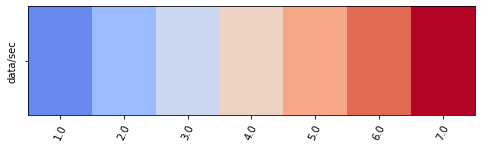

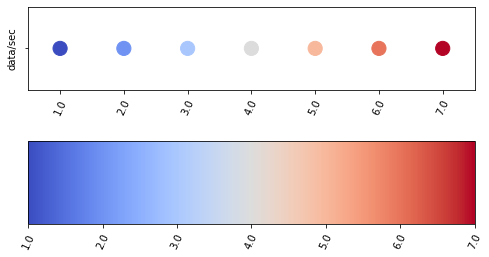

In [25]:
# Load the paths into STK, pick from a color map or specify a specifc color

# Create intervals for each edge and count the number of times the edge is active
# Optionally specify an edge weight which will be multipled by its frequency at each time step
timesEdgeCountAll = createTimesEdgesCountFromDF(df)

# # Consider binning the counts to prevent a ton of unique colors, which can noteably speed up the time it takes to add data to STK
# # Look at the pd.cut documentation for specifying specific bin edges
# numBins = 5
# bins = pd.cut(timesEdgeCountAll[:,2],numBins,labels=False)
# timesEdgeCountAll[:,2] = np.round(bins*(max(timesEdgeCountAll[:,2])-min(timesEdgeCountAll[:,2]))/numBins+min(timesEdgeCountAll[:,2]),6)

t1 = time.time()
# Color Maps here: https://matplotlib.org/stable/tutorials/colors/colormaps.html
# Good options: diverging and sequential color maps such as: cool,coolwarm,Wistia
cmap = cm.get_cmap('coolwarm') # pick a matplotlib color map or don't pass in a colorMap to just use a color
addTimesEdgesCountAsObjectLines(stkRoot,timesEdgeCountAll,step,addTo2D=False,color='%000196196',colorMap=cmap,lineWidth=7)
print(time.time()-t1)

if cmap:
    plotColorbar(timesEdgeCountAll,cmap,plotBoth=True,tickRotationInDeg=65)